In [1]:
# Set up Notebook
%matplotlib inline

# Standard imports
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm


# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

### Read in data

In [2]:
# Malawi Data
url_mw = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/mw_dataset_cluster.csv'
mw_village = pd.read_csv(url_mw)
mw_village = mw_village.drop('yearmon',axis=1)


# Tanzania Data 
url_tz = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/tz_dataset_cluster.csv'
tz_village = pd.read_csv(url_tz)

# Uganda Data 
url_ug = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/ug_dataset_cluster.csv'
ug_village = pd.read_csv(url_ug)


ug_village = ug_village.replace([np.inf, -np.inf], np.nan)
ug_village = ug_village.dropna()

# Malawi household Data
url_mw_hh = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/household/mw_hh_aggregate.csv'
mw_hh = pd.read_csv(url_mw_hh)

 
# Tanzania household Data 
url_tz_hh = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/household/tz_hh_aggregate.csv'
tz_hh = pd.read_csv(url_tz_hh)
tz_hh=tz_hh.rename(index=str, columns={"clusterid": "ea_id"})

# Uganda household Data 
url_ug_hh = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/household/ug_hh_aggregate.csv'
ug_hh = pd.read_csv(url_ug_hh)
ug_hh = ug_hh[["HHID","FCS","FS_month","FS_year","ea_id"]] 
 

# check for any missing values (should return false)
print(ug_village.isnull().values.any())
print(tz_village.isnull().values.any())
print(mw_village.isnull().values.any())


# check for any missing values (should return false)
print(ug_hh.isnull().values.any())

False
False
True
False


In [16]:
sum(ug_village.isnull().values)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Generate different outcome variable

In [4]:
def categorize_fs_three(df, measure):
    '''
    helper function to categorize continous food measure based on given cutoffs to cut into three categories 
    '''
    
    if ( measure == 'FCS'):
        labels = [2,1,0]
        bins= [-1,28,42,200]
        
    elif (measure == 'rCSI'):   
        labels = [0,1,2]
        bins= [-1,4,17,50]
        
    categorized = measure + '_3_category'
    
    df[categorized] = pd.cut( x= df[measure], bins = bins, labels = labels)
    
    return df 

def categorize_fs_binary(df, measure):
    '''
    helper function to categorize continous food measure based on binary cutoffs
    '''
    if ( measure == 'FCS'):
        labels = [1,0]
        bins= [-1,42,200]
        
    elif (measure == 'rCSI'):   
        labels = [0,1]
        bins= [-1,4,50]
        
    categorized = measure + '_binary_category'
    
    df[categorized] = pd.cut( x= df[measure], bins = bins, labels = labels)
    
    return df 

def category_percent(df,measure,category):
    '''
    helper function to 
    calculate the percent of a certain food security category in a given country 
    '''
    
    categorized = measure + '_3_category'
    
    category_name = '_low_' if category==2 else '_mid_'

    count_name = measure + category_name + 'count'
    
    percent_name = measure + category_name + 'percent'
    
    df_count = df[df[categorized]==category].groupby(['ea_id','FS_year']).count().reset_index()[['ea_id','FS_year',categorized]]
    df_count.columns=['ea_id','FS_year',count_name]
    
    df_total= df.groupby(['ea_id','FS_year']).count().reset_index()[['ea_id','FS_year',measure]]
    df_total.columns=['ea_id','FS_year','num_hh']
  
    df_percent = pd.merge(df_total, df_count, on=['ea_id','FS_year'])
    df_percent[percent_name] = round(df_percent[count_name]/df_percent['num_hh'],3)
    
    df_percent = df_percent.drop(columns= ['num_hh'])
        
    return df_percent

def village_percent(df_village,df_hh,measure): 
    '''
    calculate and merge the percent numbers into village level dfs
    '''
    
    df_hh=categorize_fs_three(df_hh,measure=measure)
    
        
    df_category_mid = category_percent(df_hh,measure=measure,category=1)
    df_category_low = category_percent(df_hh,measure=measure,category=2)

    
    df_village = pd.merge(df_village, df_category_mid, on=['ea_id','FS_year'])
    df_village = pd.merge(df_village, df_category_low, on=['ea_id','FS_year'])
    
    df_village[measure+'_mid+low'] = df_village[measure+'_low_percent'] + df_village[measure +'_mid_percent']
    
    df_village=categorize_fs_three(df_village,measure=measure)
    df_village=categorize_fs_binary(df_village,measure=measure)

       

    return df_village

In [5]:
df_village_list = [mw_village,tz_village,ug_village]
df_hh_list = [mw_hh,tz_hh,ug_hh]
measure_list = ['FCS','rCSI']

for index in range(len(df_village_list)):
      
    df_village_list[index] = village_percent(df_village_list[index],df_hh_list[index],measure='FCS') 

for index in range(len(df_village_list)-1):
      
    df_village_list[index] = village_percent(df_village_list[index],df_hh_list[index],measure='rCSI') 

mw_village = df_village_list[0]
tz_village = df_village_list[1]
ug_village = df_village_list[2]
    

In [6]:
tz_village.columns

Index(['ea_id', 'FS_year', 'FCS', 'HDDS', 'rCSI', 'rural', 'FS_month',
       'region2', 'region3', 'region4',
       ...
       'FCS_mid+low', 'FCS_3_category', 'FCS_binary_category',
       'rCSI_mid_count', 'rCSI_mid_percent', 'rCSI_low_count',
       'rCSI_low_percent', 'rCSI_mid+low', 'rCSI_3_category',
       'rCSI_binary_category'],
      dtype='object', length=119)

### Train Test split


In [7]:
def year_split(country, df):
    if country == "mw":
        test_year = 2015
    elif country == "tz":
        test_year = 2013
    elif country == "ug":
        test_year = 2011
    
    df_test = df[df['FS_year']>test_year]
    df_train = df[df['FS_year']<test_year]

    return df_test,df_train 
          

def separate_y(country,df_test,df_train):
    if country != "ug":
        labels = ['FCS', 'rCSI']
        category_labels = ['FCS_3_category', 'FCS_binary_category', 'rCSI_3_category','rCSI_binary_category']
        percent_labels = ['FCS_mid_count', 'FCS_mid_percent', 'FCS_low_count', 'FCS_low_percent','FCS_mid+low','rCSI_mid_count','rCSI_mid_percent', 'rCSI_low_count','rCSI_low_percent', 'rCSI_mid+low']
               
    elif country == "ug":      
        labels = ['FCS']
        category_labels = ['FCS_3_category', 'FCS_binary_category']
        percent_labels = ['FCS_mid_count', 'FCS_mid_percent', 'FCS_low_count', 'FCS_low_percent','FCS_mid+low']
    
    id_vars = ["ea_id","FS_year","lat_modified","lon_modified","HDDS","FNID"]
    X_test = df_test.drop(labels+category_labels+percent_labels+id_vars,  axis=1)
    X_train = df_train.drop(labels+category_labels+percent_labels+id_vars,  axis=1)
    y_train_category = df_train[category_labels]
    y_test_category = df_test[category_labels]
    y_train_percent = df_train[percent_labels]
    y_test_percent = df_test[percent_labels]

    return X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent

### Model pipeline

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import numpy as np

def lrCLF(X_train,y_train,X_test, y_test,prob=False):
    '''logistic'''
    lr_clf = LogisticRegression(random_state=66, solver='lbfgs',
                              multi_class='multinomial')
    lr_clf.fit(X_train, y_train)

    y_pred = lr_clf.predict(X_test)
     
    if prob==False:
        y_pred = lr_clf.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = lr_clf.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test
      

def treeCLF(X_train,y_train,X_test, y_test,prob=False):
    '''Tree'''
    # Define tree classifier
    tree_clf = DecisionTreeClassifier(random_state=66)
    
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]
    # n_estimators = [int(x) for x in np.linspace(1, 10, num = 5)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    tree_random = RandomizedSearchCV(estimator = tree_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


    tree_random.fit( X_train, y_train)

    if prob==False:
        y_pred = tree_random.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = tree_random.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test
    
    
def rfCLF(X_train,y_train,X_test, y_test,prob=False):
    
    '''rfc'''
    rf_clf = RandomForestClassifier(max_features='auto', n_estimators = 500,min_samples_split=10,warm_start=True)

    # Define rfc classifier
    max_depth = [int(x) for x in np.linspace(12, 30, num = 10)]
    max_features = [int(x) for x in np.linspace(8, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    rf_random = RandomizedSearchCV(estimator = rf_clf, 
            param_distributions = random_grid,
            refit ='recall', 
            n_iter = 30, cv = 3, verbose=0, random_state=666, 
            n_jobs = -1)


    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    if prob==False:
        y_pred = rf_random.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = rf_random.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test
    

def xgbCLF(X_train,y_train,X_test, y_test,prob=False):
    '''XGB'''

    # fit model on  training data
    XGB_clf = XGBClassifier(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.3,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          #objective='multi:softmax', 
                          #num_class=14,
                          n_estimators=100, 
                          reg_alpha = 0.3,
                          max_depth=5, 
                          gamma=10)
    
    max_depth = [int(x) for x in np.linspace(2, 5, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    XGB_random = RandomizedSearchCV(estimator = XGB_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=0, random_state=666, n_jobs = -1)
    # Fit the random search model
    
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    
    XGB_random.fit(X_train, y_train)
    
    if prob==False:
        y_pred = XGB_random.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = XGB_random.predict_proba(X_test)[:, 1]
        return y_prob,y_test

def pre_rec_f1_support_minority(y_pred,y_test):
    
    if len(precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3])==3:
        precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][2]
        recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][2]
        fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][2]
        support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][2]

    elif len(precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3])==2:
 #   precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][1]
 #   recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][1]
 #   fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][1]
 #   support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][1]

        precision = np.nan
        recall = np.nan
        fscore = np.nan
        support = np.nan

    accuracy = accuracy_score(y_pred,y_test)

    return precision,recall,fscore,support,accuracy    
 
def pre_rec_f1_support_mid(y_pred,y_test):

    precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][1]
    recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][1]
    fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][1]
    support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][1]
    accuracy = accuracy_score(y_pred,y_test)

    return precision,recall,fscore,support,accuracy        

def metrics_3_category_severe(country,df,measure,model):
    
    category = measure+'_3_category'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_category[category],X_test,y_test_category[category])
    
    precision,recall,fscore,support,accuracy = pre_rec_f1_support_minority(y_pred,y_test)
    
    result_row = [[country,measure, model.__doc__, precision,recall,fscore,support,accuracy]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

    return result_df

def metrics_3_category_mid(country,df,measure,model):
    
    category = measure+'_3_category'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_category[category],X_test,y_test_category[category])
    
    precision,recall,fscore,support,accuracy = pre_rec_f1_support_mid(y_pred,y_test)
    
    result_row = [[country,measure, model.__doc__, precision,recall,fscore,support,accuracy]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

    return result_df



### Three category results 

In [9]:
# create a table of results for the third category

third_category_severe = pd.DataFrame(columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

model_list= [lrCLF,treeCLF,rfCLF,xgbCLF]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                third_category_severe = third_category_severe.append(metrics_3_category_severe(country,df,measure,model),ignore_index=True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [11]:
third_category_severe

,country,measure,model,precision,recall,fscore,support,accuracy
0,mw,FCS,logistic,NaN,NaN,NaN,NaN,0.552980
1,mw,rCSI,logistic,0.0,0.0,0.0,6.0,0.705298
2,tz,FCS,logistic,0.0,0.0,0.0,1.0,0.428571
3,tz,rCSI,logistic,0.5,0.5,0.5,2.0,0.928571
4,ug,FCS,logistic,0.0,0.0,0.0,6.0,0.555556
5,mw,FCS,Tree,NaN,NaN,NaN,NaN,0.615894
6,mw,rCSI,Tree,0.0,0.0,0.0,6.0,0.500000
7,tz,FCS,Tree,0.0,0.0,0.0,1.0,0.464286
8,tz,rCSI,Tree,0.0,0.0,0.0,2.0,0.928571
9,ug,FCS,Tree,0.0,0.0,0.0,6.0,0.438889


In [12]:
# create a table of results for the third category

third_category_mid= pd.DataFrame(columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

model_list= [lrCLF,treeCLF,rfCLF,xgbCLF]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                third_category_mid = third_category_mid.append(metrics_3_category_mid(country,df,measure,model),ignore_index=True)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s



Fitting 3 folds for each of 30 candidates, totalling 90 fits

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


In [13]:
third_category_mid

,country,measure,model,precision,recall,fscore,support,accuracy
0,mw,FCS,logistic,1.000000,0.007353,0.014599,136,0.552980
1,mw,rCSI,logistic,0.804781,0.834711,0.819473,242,0.705298
2,tz,FCS,logistic,0.405405,0.625000,0.491803,24,0.428571
3,tz,rCSI,logistic,0.944444,0.980769,0.962264,52,0.928571
4,ug,FCS,logistic,0.550000,0.268293,0.360656,82,0.555556
5,mw,FCS,Tree,0.884615,0.169118,0.283951,136,0.615894
6,mw,rCSI,Tree,0.786164,0.516529,0.623441,242,0.500000
7,tz,FCS,Tree,0.272727,0.125000,0.171429,24,0.464286
8,tz,rCSI,Tree,0.928571,1.000000,0.962963,52,0.928571
9,ug,FCS,Tree,0.440994,0.865854,0.584362,82,0.438889


### Two category ROC curves

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
    
def roc_curve_measure(country,df,measure):
    
    category = measure+'_binary_category'
     
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)

    # baseline
    y_prob,y_test  = lrCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)
    
    # Tree
    y_prob,y_test  = treeCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve of Tree model (area = %0.3f)' % roc_auc)

    # rfc
    y_prob,y_test  = rfCLF (X_train,y_train_category[category],X_test,y_test_category[category],prob=True )
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

    # XGB
    y_prob,y_test  = xgbCLF (X_train,y_train_category[category],X_test,y_test_category[category],prob=True )
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)
    
    
    # Plot the grid
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or Recall')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="mider right")

    plt.savefig('output/graphs/roc/'+country+'_'+measure+'_roc.png', bbox_inches='tight')


    return plt.show()

 




Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.8s finished


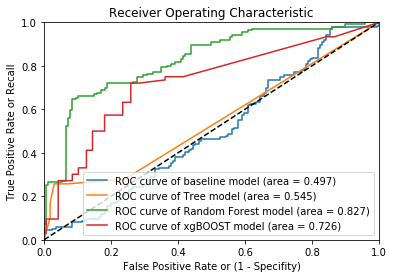

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


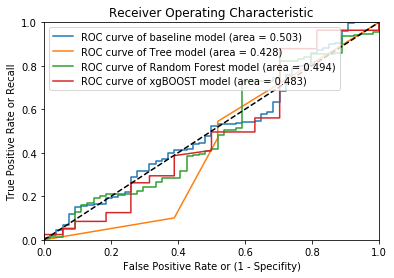

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


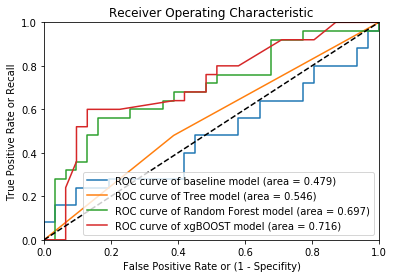

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


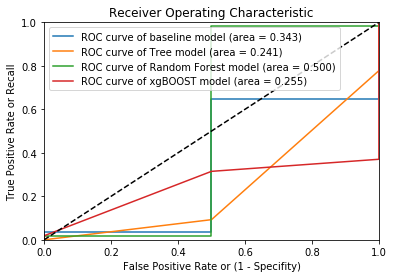

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.0s finished


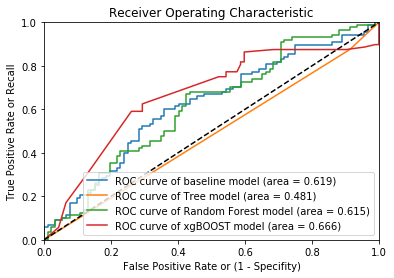

In [17]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village

            roc_curve_measure(country,df,measure)

### Percentage of insecure

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import pearsonr

def lr(X_train,y_train,X_test, y_test):
    '''linear_reg'''
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    return y_test,y_pred

def lasso(X_train,y_train,X_test, y_test):
    '''lasso'''
    reg = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6, 1],
                        max_iter=500, cv=10).fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    return y_test,y_pred

def rf(X_train,y_train,X_test, y_test):
    '''rfc'''
    rf_reg = RandomForestRegressor(max_features='auto', n_estimators = 500,warm_start=True)

    max_depth = [int(x) for x in np.linspace(12, 30, num = 10)]
    max_features = [int(x) for x in np.linspace(8, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    rf_random = RandomizedSearchCV(estimator = rf_reg, 
            param_distributions = random_grid,
            refit ='recall', 
            n_iter = 30, cv = 3, verbose=0, random_state=666, 
            n_jobs = -1)


    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    y_pred = rf_random.predict(X_test)
    
    return y_test,y_pred

def xgb(X_train,y_train,X_test, y_test,prob=False):
    '''XGB'''

    # fit model on  training data
    XGB_reg = XGBRegressor(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.3,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          #objective='multi:softmax', 
                          #num_class=14,
                          n_estimators=100, 
                          reg_alpha = 0.3,
                          max_depth=5, 
                          gamma=10)
   
    max_depth = [int(x) for x in np.linspace(2, 5, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    XGB_random = RandomizedSearchCV(estimator = XGB_reg, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=0, random_state=666, n_jobs = -1)
    # Fit the random search model
    
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    
    XGB_random.fit(X_train, y_train)
    y_pred = XGB_random.predict(X_test)
         
    return y_test,y_pred
    
def r2_percent_low(country,df,measure,model):
    
    percent = measure+'_low_percent'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_percent[percent],X_test,y_test_percent[percent])
    r2= round(pearsonr(y_pred,y_test)[1],3)
    
    result_row = [[country,measure, model.__doc__, r2]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model','r2']) 

    return result_df

def r2_percent_mid_low(country,df,measure,model):
    
    percent = measure+'mid+low'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_percent[percent],X_test,y_test_percent[percent])
    r2= round(pearsonr(y_pred,y_test)[1],3)    
    result_row = [[country,measure, model.__doc__, r2]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model','r2']) 

    return result_df

In [23]:
percent_results_low = pd.DataFrame(columns = ['country','measure','model', 'r2']) 

model_list= [lr,lasso,rf,xgb]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                percent_results_low = percent_results_low.append(r2_percent_low(country,df,measure,model),ignore_index=True)
percent_results_low                

,country,measure,model,r2
0,mw,FCS,linear_reg,0.000
1,mw,rCSI,linear_reg,0.001
2,tz,FCS,linear_reg,0.315
3,tz,rCSI,linear_reg,0.811
4,ug,FCS,linear_reg,0.966
5,mw,FCS,lasso,0.000
6,mw,rCSI,lasso,NaN
7,tz,FCS,lasso,0.810
8,tz,rCSI,lasso,0.612
9,ug,FCS,lasso,0.634


In [36]:
mw_village['rCSI_low_percent'].unique()

array([0.375, 0.062, 0.118, 0.056, 0.136, 0.188, 0.182, 0.176, 0.125,
       0.438, 0.045, 0.034, 0.043, 0.08 , 0.158, 0.053, 0.05 , 0.059,
       0.143, 0.133, 0.211, 0.238, 0.13 , 0.105, 0.077, 0.091, 0.087,
       0.25 , 0.1  , 0.048, 0.083, 0.071, 0.132, 0.167, 0.067, 0.15 ,
       0.273, 0.227, 0.095, 0.455, 0.261, 0.35 , 0.312, 0.29 , 0.031,
       0.208, 0.226, 0.32 , 0.2  , 0.389, 0.19 , 0.231, 0.667, 0.444,
       0.111, 0.148, 0.333, 0.103, 0.304, 0.185, 0.267, 0.042, 0.4  ,
       0.5  , 0.409, 0.286, 0.04 , 0.174])

In [27]:
mw_village.columns

Index(['ea_id', 'FS_year', 'FNID', 'FCS', 'HDDS', 'rCSI', 'region_north',
       'region_central', 'rural', 'lat_modified', 'lon_modified', 'dist_road',
       'dist_admarc', 'dist_popcenter', 'percent_ag',
       'nutri_severe_constraint', 'nutri_moderate_constraint',
       'nutri_reten_severe_constraint', 'dummy_terrain_rough', 'FS_month',
       'head_age', 'female_head', 'hhsize', 'floor_dirt_sand_dung',
       'cell_phone', 'number_celphones', 'roof_not_natural', 'roof_iron',
       'asset_index', 'clust_maize_price', 'clust_rice_price',
       'clust_nuts_price', 'clust_beans_price', 'clust_maize_mktthin',
       'clust_rice_mktthin', 'clust_nuts_mktthin', 'clust_beans_mktthin',
       'lhz_maize_price', 'lhz_rice_price', 'lhz_nuts_price',
       'lhz_beans_price', 'lhz_maize_mktthin', 'lhz_rice_mktthin',
       'lhz_nuts_mktthin', 'lhz_beans_mktthin', 'raincytot', 'day1rain',
       'maxdaysnorain', 'lhz_day1rain', 'gdd', 'tmean', 'lhz_raincytot',
       'lhz_maxdaysnorain', 'h

### Oversample for three class

In [ ]:
from sklearn.utils import resample

def upsample_minority(country,df,measure)

    mw11_rCSI_df = pd.concat([mw_clust_X_train_11, mw_clust_y_train_11['rCSI_category']], axis=1)

    mw11_rCSI_not_crisis = mw11_rCSI_df[mw11_rCSI_df.rCSI_category!=2]
    mw11_rCSI_crisis = mw11_rCSI_df[mw11_rCSI_df.rCSI_category==2]

    # separate minority and majority classes

    # upsample minority
    mw11_rCSI_crisis_upsampled = resample(mw11_rCSI_not_crisis,replace=True, # sample with replacement
                                     n_samples=len(mw11_rCSI_crisis), # match number in majority class
                                     random_state=27) # reproducible results
    # combine majority and upsampled minority
    mw11_rCSI_upsampled = pd.concat([mw11_rCSI_not_crisis, mw11_rCSI_crisis_upsampled])

    mw11_rCSI_upsampled_upsampled_y_train = mw11_rCSI_upsampled["rCSI_category"]

    mw11_rCSI_upsampled_X_train = mw11_rCSI_upsampled.drop("rCSI_category",axis=1)

    return X_train,y_train

from imblearn.combine import SMOTETomek

def upsample_minority(country,df,measure)

    smt = SMOTETomek(random_state=42,sampling_strategy='minority')

    mw_smote_X_train_fcs_11, mw_smote_y_train_fcs_11 = smt.fit_resample(mw_clust_X_train_11, mw_clust_y_train_11['FCS_category'])

    mw_smote_X_train_fcs_13, mw_smote_y_train_fcs_13 = smt.fit_resample(mw_clust_X_train_13, mw_clust_y_train_13['FCS_category'])

    mw_smote_X_train_fcs_16, mw_smote_y_train_fcs_16 = smt.fit_resample(mw_clust_X_train_16, mw_clust_y_train_16['FCS_category'])

    mw_smote_X_train_rCSI_11, mw_smote_y_train_rCSI_11 = smt.fit_resample(mw_clust_X_train_11, mw_clust_y_train_11['rCSI_category'])

    mw_smote_X_train_rCSI_13, mw_smote_y_train_rCSI_13 = smt.fit_resample(mw_clust_X_train_13, mw_clust_y_train_13['rCSI_category'])

    smt_non = SMOTETomek(random_state=42,sampling_strategy='not minority')
    
from imblearn.over_sampling import ADASYN

def upsample_minority(country,df,measure)

    ada = ADASYN(random_state=42,n_jobs=5,sampling_strategy='minority')


    mw_ADA_X_train_fcs_11, mw_ADA_y_train_fcs_11 = ada.fit_resample(mw_clust_X_train_11, mw_clust_y_train_11['FCS_category'])

    mw_ADA_X_train_fcs_13, mw_ADA_y_train_fcs_13 = ada.fit_resample(mw_clust_X_train_13, mw_clust_y_train_13['FCS_category'])




### Feature importance

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=66)
    
max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
max_features = [int(x) for x in np.linspace(3, 20, num = 10)]
# n_estimators = [int(x) for x in np.linspace(1, 10, num = 5)]

random_grid = {#'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth
                #'min_samples_split': min_samples_split
                #'min_samples_leaf': min_samples_leaf}
                #'bootstrap': bootstrap
                }

tree_random = RandomizedSearchCV(estimator = tree_clf, param_distributions = random_grid,
                                n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)

X_train = mw_clust_X_train_16
y_train = mw_clust_y_train_16['FCS_category']
tree_random.fit(X_train, y_train)

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_random.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [ ]:
rf_clf = RandomForestClassifier(max_features='auto', n_estimators = 100,min_samples_split=10,warm_start=True)

        
# Define rfc classifier
max_depth = [int(x) for x in np.linspace(12, 30, num = 10)]
max_features = [int(x) for x in np.linspace(8, 20, num = 10)]

random_grid = {#'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth
              #'min_samples_split': min_samples_split
              #'min_samples_leaf': min_samples_leaf}
              #'bootstrap': bootstrap
              }

rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid,
                              n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


# Fit the random search model
rf_random.fit(X_train, y_train)

### Error Analysis

In [ ]:
ug12 = pd.DataFrame({ 'ug12_FCS_truth':ug12_FCS_truth, 'ug_FCS_LR' : ug12_FCS_LR, 'ug_FCS_RFC' : ug12_FCS_RFC}).reset_index(drop=True)
ug_map = pd.concat([ug_ea_id.reset_index(drop=True),ug12 ], axis=1, ignore_index=True)
ug_map.columns=['ea_id','FS_year','lat_modified','lon_modified','ug12_FCS_truth','ug_FCS_LR','ug_FCS_RFC']



### Household level predictions